# Lab 6

### <span style="color:chocolate"> Submission requirements </span>

Additional points may be deducted if these requirements are not met:
    
* Comment your code
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own
* Be sure your submitted notebook includes the output of your run (Hint: go to Kernel -> Restart Kernel and Run All Cells...)
* Try and minimize the use of the global namespace (meaning, keep things inside functions)
* Upload your .ipynb file to Gradescope when done
---

This lab connects all the pieces involved in training feed-forward fully connected neural networks. You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for both the MNIST and FASHION_MNIST datasets, and report your findings.

In [36]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras import regularizers
from keras.utils import to_categorical

tf.get_logger().setLevel('INFO')

## Datasets


### Fashion MNIST

We load the fashion_mnist dataset as before.

Label: t-shirt


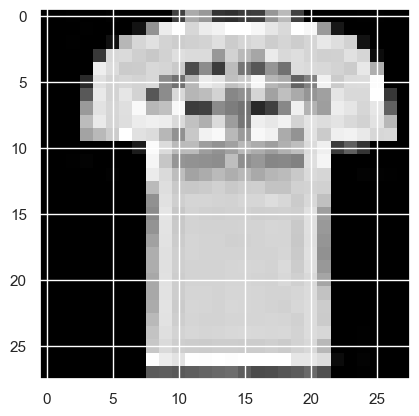

In [37]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

# Show the first training example.
print('Label: %s' %label_names[Y_train_fashion[0]])
plt.imshow(X_train_fashion[0], cmap='gray')
plt.show()

In [38]:
X_train_fashion[0].shape

(28, 28)

### MNIST

We also load the (digits) mnist dataset in the same way. Note that the number of train/test examples as well as the data shapes are identical to fashion_mnist.

Label: 3


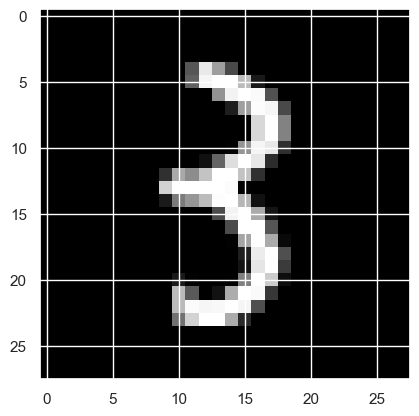

In [39]:
from keras.datasets import mnist

# Load the MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()
X_train_digits = X_train_digits / 255
X_test_digits = X_test_digits / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

# Show the first training example.
print('Label: %d' %Y_train_digits[0])
plt.imshow(X_train_digits[0], cmap='gray')
plt.show()

## Build a Model

We will write a build_model function that allows for a range of experiments on both datasets.

---
### Exercise 1 (50 points)

Fill in code that implements the build_model function, including all the arguments listed in the function definition [Note: the activation function parameter is only for the the hidden layers, use the appropriate final classification function for the final layer as usual].

In [40]:
# Get shapes of datasets.
print('X_train_fashion shape:', X_train_fashion.shape)
print('Y_train_fashion shape:', Y_train_fashion.shape)
print('X_test_fashion shape:', X_test_fashion.shape)
print('Y_test_fashion shape:', Y_test_fashion.shape)
print('X_train_digits shape:', X_train_digits.shape)
print('Y_train_digits shape:', Y_train_digits.shape)
print('X_test_digits shape:', X_test_digits.shape)
print('Y_test_digits shape:', Y_test_digits.shape)

X_train_fashion shape: (60000, 28, 28)
Y_train_fashion shape: (60000,)
X_test_fashion shape: (10000, 28, 28)
Y_test_fashion shape: (10000,)
X_train_digits shape: (60000, 28, 28)
Y_train_digits shape: (60000,)
X_test_digits shape: (10000, 28, 28)
Y_test_digits shape: (10000,)


In [41]:
def build_model(n_classes, hidden_layer_sizes=[], activation='relu', optimizer='SGD', learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.

    Args:
      n_classes: Number of output classes in the dataset.
      hidden_layer_sizes: A list with the number of units in each hidden layer.
      activation: The activation function to use for the hidden layers.
      optimizer: The optimizer to use (SGD, Adam).
      learning_rate: The desired learning rate for the optimizer.

    Returns:
      model: A tf.keras model (graph).
    """
    tf.random.set_seed(0)

    # Create a sequential model.
    model = tf.keras.models.Sequential()

    # Add the input layer
    model.add(tf.keras.layers.Input(shape=(28, 28), name='input_layer'))
              
    # Add a flatten layer
    model.add(tf.keras.layers.Flatten(name='flatten_layer'))

    # Add the hidden layers if there is at least one hidden layer
    if len(hidden_layer_sizes) >= 1 and hidden_layer_sizes[0] != 0:
        for i in range(len(hidden_layer_sizes)):
            model.add(tf.keras.layers.Dense(hidden_layer_sizes[i], activation=activation, kernel_regularizer=regularizers.l2(0.01),name=f'hidden_layer_{i}'))

    # Add a dropout layer
    model.add(tf.keras.layers.Dropout(rate=0.3, name='dropout_layer'))

    # Add the output layer with softmax activation
    model.add(tf.keras.layers.Dense(n_classes, activation=tf.keras.activations.softmax, name='output_layer'))

    # Set optimizer
    if optimizer == 'SGD':
        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    else:
        raise ValueError('Invalid optimizer parameter: Enter SGD or Adam')

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model

---

## Run Experiments

We can now run a suite of experiments to see how the hyperparameters and layer sizes effect performance. The train_and_evaluate function below can be used to run experiments and retrieve results.

In [42]:
def train_and_evaluate(data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5):

  # Build the model.
  model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Select the dataset.
  if data == 'digits':
    X_train = X_train_digits
    X_test = X_test_digits
    Y_train = Y_train_digits
    Y_test = Y_test_digits
  elif data == 'fashion':
    X_train = X_train_fashion
    X_test = X_test_fashion
    Y_train = Y_train_fashion
    Y_test = Y_test_fashion
  else:
    raise 'Unsupported dataset: %s' %data

  # One-hot encode the target labels
  Y_train = to_categorical(Y_train_digits)
  Y_test = to_categorical(Y_test_digits)

  # Train the model
  print('Training...')
  history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch)
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  # Plot loss and accuracy for training and validation sets
  fig = plt.figure(figsize=(12, 4))
  
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(train_loss, label='Train Loss')
  ax1.plot(val_loss, label='Validation Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.set_title('Loss vs. Epoch')
  ax1.legend()
  if data == 'digits':
    ax1.set_ylim([0, 1.2])
  elif data == 'fashion':
    ax1.set_ylim([0, 2.4])

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot(train_accuracy, label='Train Accuracy')
  ax2.plot(val_accuracy, label='Validation Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Accuracy vs. Epoch')
  ax2.legend()
  ax2.set_ylim([0, 1])
  plt.show()

  # Evaluate the model on the test set
  test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,
                                 return_dict=True)['accuracy']
  
  return test_accuracy, model.summary()

# Create a wrapper function to run experiment with different hyperparameters
def run_experiment(data='digits',
                  hidden_layer_sizes=[],
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.01,
                  num_epochs=5):
    test_accuracy, summary = train_and_evaluate(data=data, 
                                                hidden_layer_sizes=hidden_layer_sizes,
                                                activation=activation,
                                                optimizer=optimizer,
                                                learning_rate=learning_rate,
                                                num_epochs=num_epochs)
    
    # Print parameters
    print('Data: %s, Hidden layer sizes: %s, Activation: %s, Optimizer: %s, Learning rate: %s' %(data, hidden_layer_sizes, activation, optimizer, learning_rate))

    # Output summary
    summary
    
    # Print test accuracy
    print('Test accuracy: %.2f' %test_accuracy)

Training...


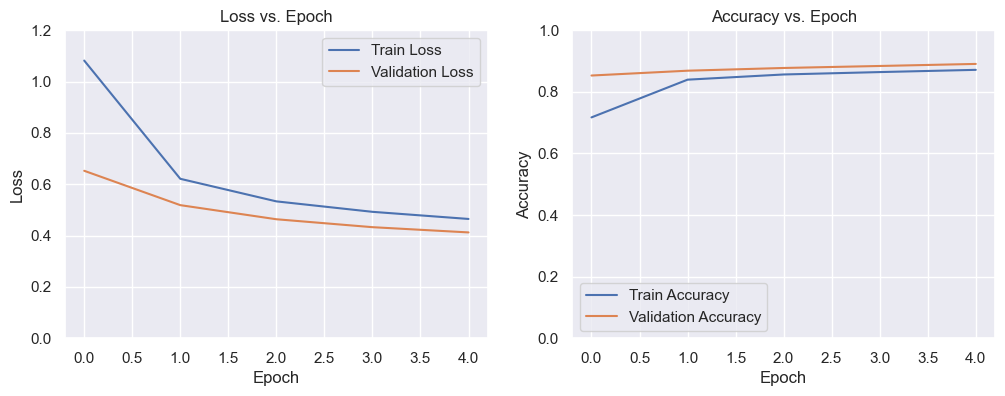

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 dropout_layer (Dropout)     (None, 784)               0         
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: digits, Hidden layer sizes: [], Activation: tanh, Optimizer: SGD, Learning rate: 0.01
Test accuracy: 0.90


In [43]:
# Experiment 1
run_experiment(data='digits', hidden_layer_sizes=[], activation='tanh', optimizer='SGD', learning_rate=0.01)

Training...


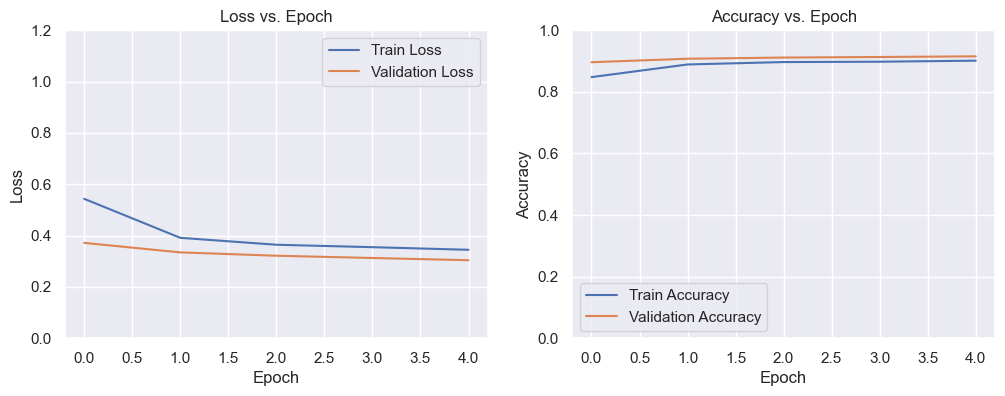

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 dropout_layer (Dropout)     (None, 784)               0         
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: digits, Hidden layer sizes: [], Activation: tanh, Optimizer: SGD, Learning rate: 0.1
Test accuracy: 0.92


In [44]:
# Experiment 1b
run_experiment(data='digits', hidden_layer_sizes=[], activation='tanh', optimizer='SGD', learning_rate=0.1)

Training...


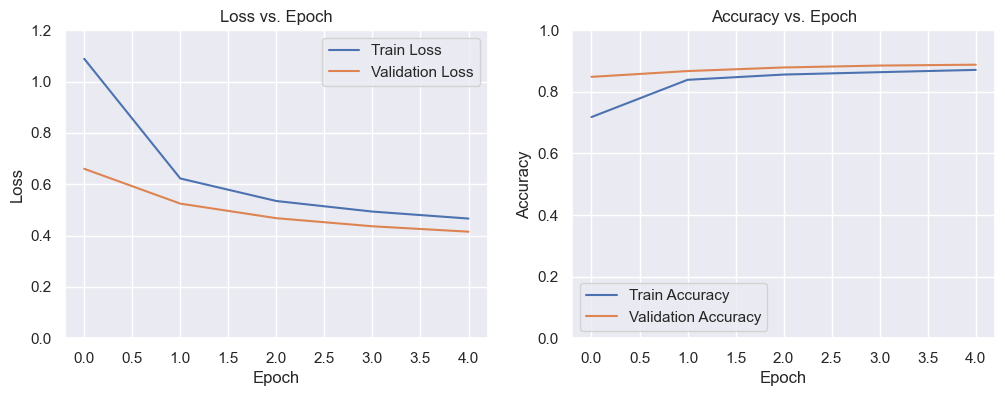

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 dropout_layer (Dropout)     (None, 784)               0         
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: digits, Hidden layer sizes: [], Activation: relu, Optimizer: SGD, Learning rate: 0.01
Test accuracy: 0.90


In [45]:
# Experiment 2
run_experiment(data='digits', hidden_layer_sizes=[], activation='relu', optimizer='SGD', learning_rate=0.01)

Training...


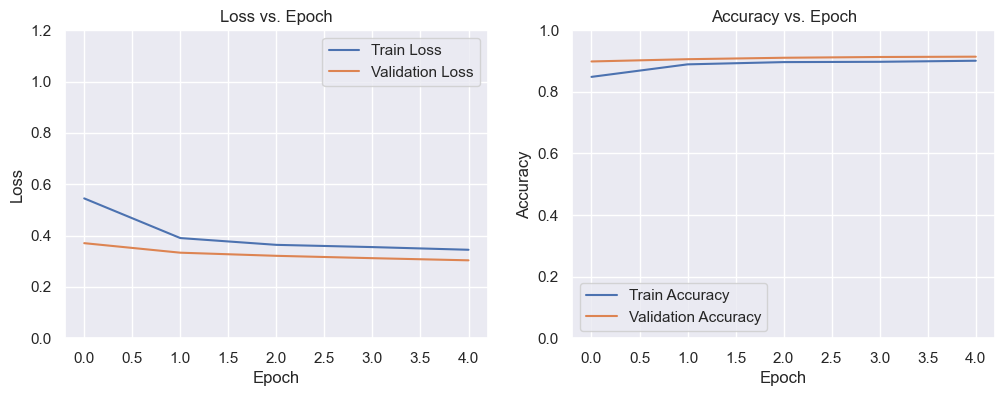

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 dropout_layer (Dropout)     (None, 784)               0         
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: digits, Hidden layer sizes: [], Activation: relu, Optimizer: SGD, Learning rate: 0.1
Test accuracy: 0.92


In [46]:
# Experiment 2b
run_experiment(data='digits', hidden_layer_sizes=[], activation='relu', optimizer='SGD', learning_rate=0.1)

Training...


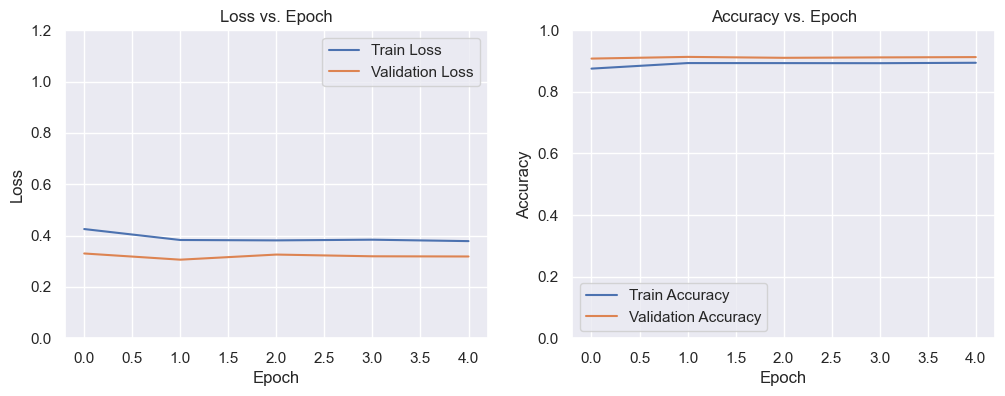

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 dropout_layer (Dropout)     (None, 784)               0         
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: digits, Hidden layer sizes: [], Activation: relu, Optimizer: Adam, Learning rate: 0.01
Test accuracy: 0.91


In [47]:
# Experiment 3
run_experiment(data='digits', hidden_layer_sizes=[], activation='relu', optimizer='Adam', learning_rate=0.01)

Training...


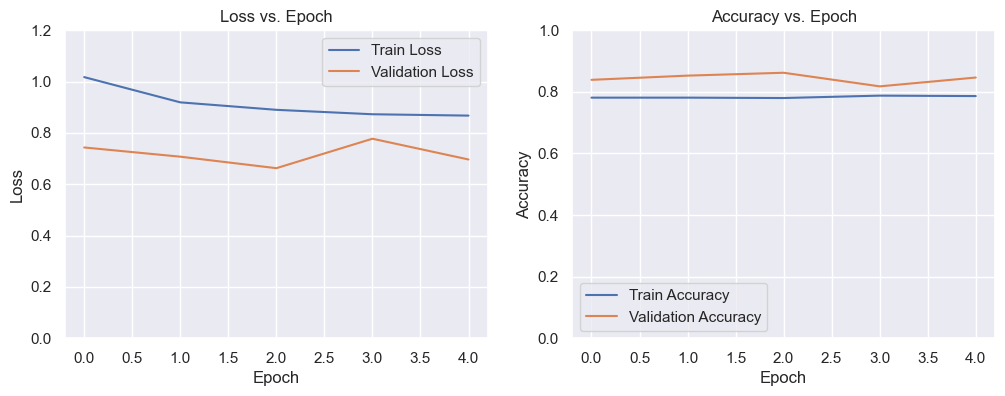

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 hidden_layer_0 (Dense)      (None, 128)               100480    
                                                                 
 dropout_layer (Dropout)     (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: digits, Hidden layer sizes: [128], Activation: relu, Optimizer: Adam, Learning rate: 0.01
Test accuracy: 0.85


In [48]:
# Experiment 4
run_experiment(data='digits', hidden_layer_sizes=[128], activation='relu', optimizer='Adam', learning_rate=0.01)

Training...


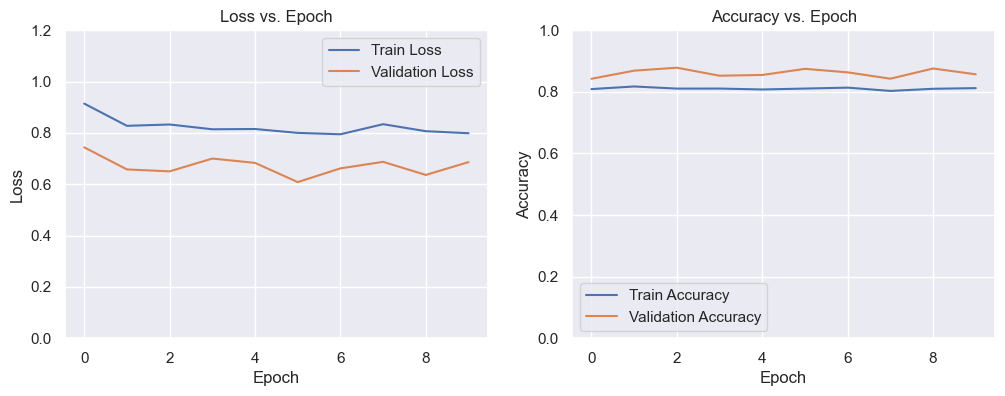

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 hidden_layer_0 (Dense)      (None, 128)               100480    
                                                                 
 dropout_layer (Dropout)     (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: digits, Hidden layer sizes: [128], Activation: relu, Optimizer: Adam, Learning rate: 0.007
Test accuracy: 0.86


In [49]:
# Experiment 4b
run_experiment(data='digits', hidden_layer_sizes=[128], activation='relu', optimizer='Adam', learning_rate=0.007, num_epochs=10)

Training...


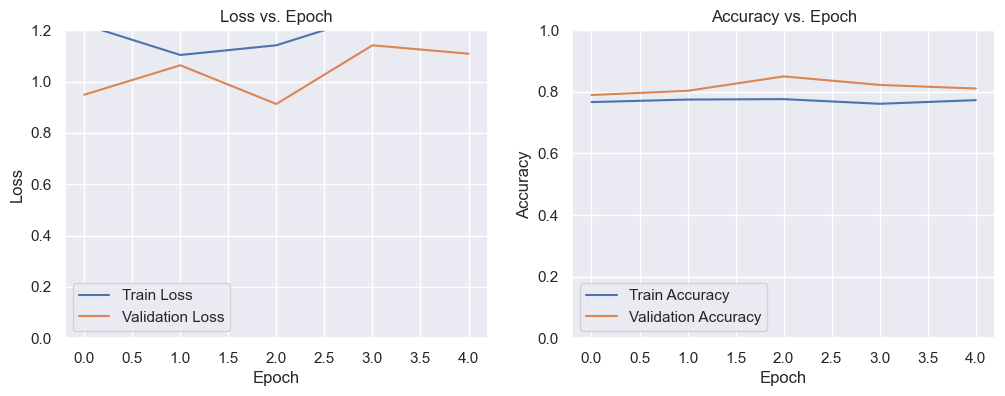

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 hidden_layer_0 (Dense)      (None, 256)               200960    
                                                                 
 hidden_layer_1 (Dense)      (None, 128)               32896     
                                                                 
 dropout_layer (Dropout)     (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: digits,

In [50]:
# Experiment 5
run_experiment(data='digits', hidden_layer_sizes=[256,128], activation='relu', optimizer='Adam', learning_rate=0.01)

Training...


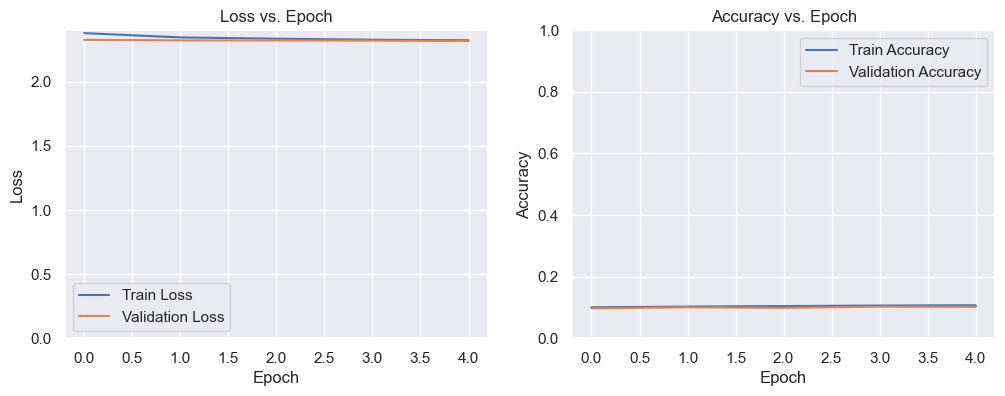

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 dropout_layer (Dropout)     (None, 784)               0         
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: fashion, Hidden layer sizes: [], Activation: tanh, Optimizer: SGD, Learning rate: 0.01
Test accuracy: 0.10


In [51]:
# Experiment 6
run_experiment(data='fashion', hidden_layer_sizes=[], activation='tanh', optimizer='SGD', learning_rate=0.01)

Training...


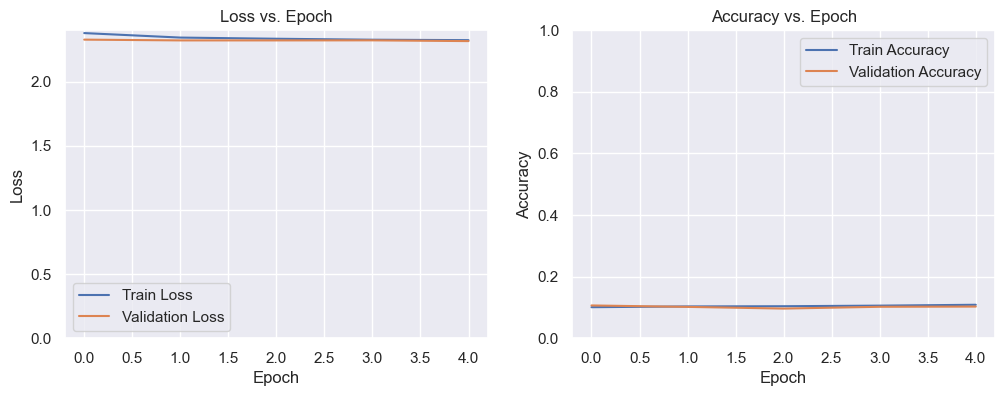

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 dropout_layer (Dropout)     (None, 784)               0         
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: fashion, Hidden layer sizes: [], Activation: relu, Optimizer: SGD, Learning rate: 0.01
Test accuracy: 0.10


In [52]:
# Experiment 7
run_experiment(data='fashion', hidden_layer_sizes=[], activation='relu', optimizer='SGD', learning_rate=0.01)

Training...


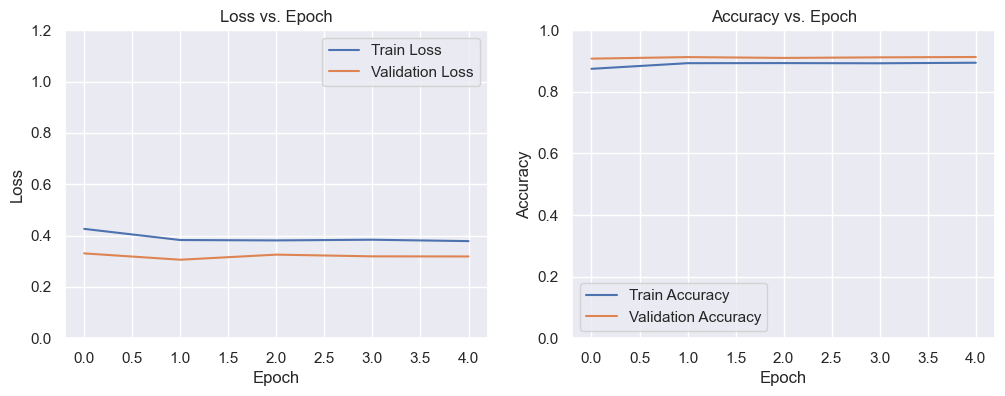

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 dropout_layer (Dropout)     (None, 784)               0         
                                                                 
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: digits, Hidden layer sizes: [], Activation: relu, Optimizer: Adam, Learning rate: 0.01
Test accuracy: 0.91


In [53]:
# Experiment 8
run_experiment(data='digits', hidden_layer_sizes=[], activation='relu', optimizer='Adam', learning_rate=0.01)

Training...


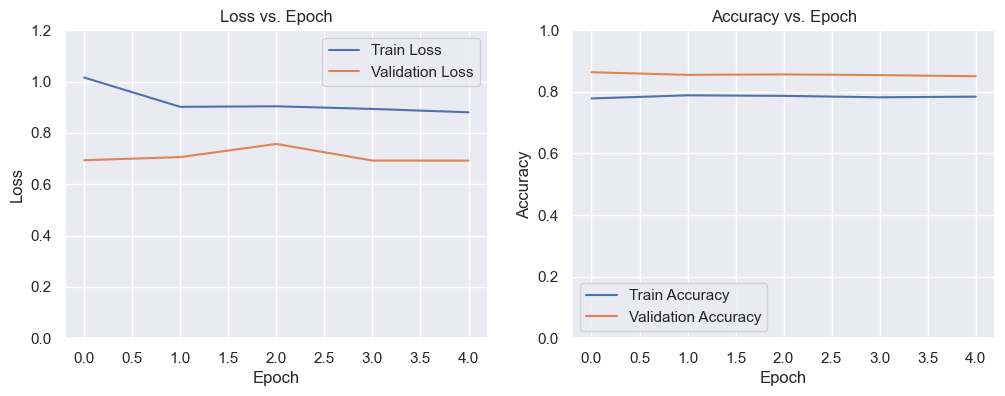

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 hidden_layer_0 (Dense)      (None, 128)               100480    
                                                                 
 dropout_layer (Dropout)     (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: digits, Hidden layer sizes: [128], Activation: relu, Optimizer: Adam, Learning rate: 0.01
Test accuracy: 0.85


In [54]:
# Experiment 9
run_experiment(data='digits', hidden_layer_sizes=[128], activation='relu', optimizer='Adam', learning_rate=0.01)

Training...


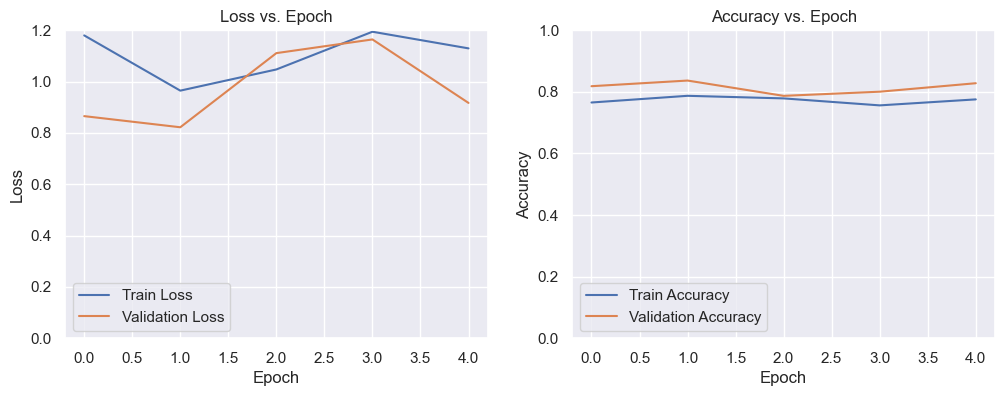

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 hidden_layer_0 (Dense)      (None, 256)               200960    
                                                                 
 hidden_layer_1 (Dense)      (None, 128)               32896     
                                                                 
 dropout_layer (Dropout)     (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: digits,

In [55]:
# Experiment 10
run_experiment(data='digits', hidden_layer_sizes=[256, 128], activation='relu', optimizer='Adam', learning_rate=0.01)

Training...


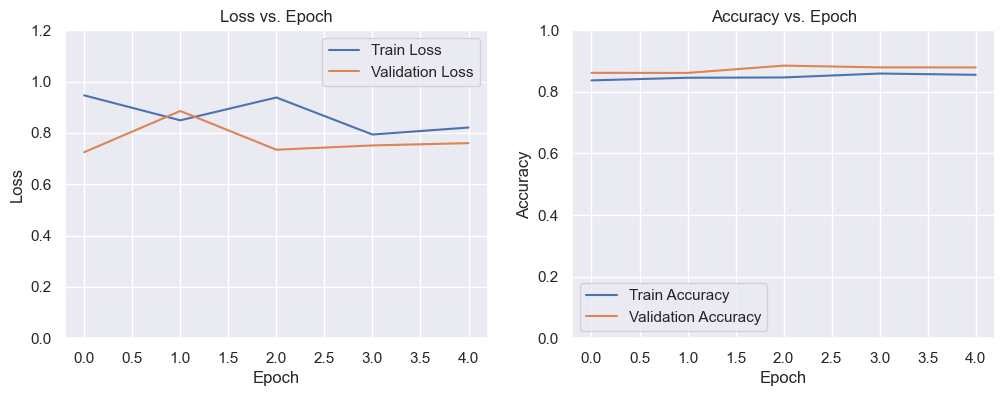

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_layer (Flatten)     (None, 784)               0         
                                                                 
 hidden_layer_0 (Dense)      (None, 256)               200960    
                                                                 
 hidden_layer_1 (Dense)      (None, 128)               32896     
                                                                 
 dropout_layer (Dropout)     (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Data: digits,

In [58]:
# Experiment 10b
run_experiment(data='digits', hidden_layer_sizes=[256, 128], activation='relu', optimizer='Adam', learning_rate=0.003, num_epochs=5)

---
### Exercise 2 (50 points)

Run experiments and fill in the test results in the table below. Feel free to extend the table to more experiments as you see fit.

#### Student Solution

DATA | HIDDEN SIZES | ACTIVATION | OPTIMIZER | #EPOCHS | LEARNING RATE | #PARAMETERS | TEST ACCURACY
-|-|-|-|-|-|-|-
digits|[]|tanh|SGD|5|0.01|7,890|0.90
digits|[]|tanh|SGD|5|0.1|7,890|0.92
digits|[]|relu|SGD|5|0.01|7,890|0.90
digits|[]|relu|SGD|5|0.1|7,890|0.92
digits|[]|relu|Adam|5|0.01|7,890|0.91
digits|[128]|relu|Adam|5|0.01|101,770|0.85
digits|[128]|relu|Adam|10|0.007|101,770|0.86
digits|[256,128]|relu|Adam|5|0.01|235,146|0.81
fashion|[]|tanh|SGD|5|0.01|7,850|0.10
fashion|[]|relu|SGD|5|0.01|7,850|0.10
fashion|[]|relu|Adam|5|0.01|7,850|0.91
fashion|[128]|relu|Adam|5|0.01|101,770|0.85
fashion|[256,128]|relu|Adam|5|0.01|235,146|0.82
fashion|[256,128]|relu|Adam|5|0.005|235,146|0.88